In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import shap
import matplotlib.pyplot as plt

In [4]:
# Ambil Dataset credit_scoring.csv
df = pd.read_csv('/content/credit_scoring.csv')
df.head()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
0,501000,41,13995609,5982664,0,624,0,0,-0.040
1,501001,58,13683833,3711198,0,809,0,0,0.001
2,501002,33,9417391,7172332,0,647,0,0,0.077
3,501003,45,6861811,8661056,0,450,0,0,0.038
4,501004,22,5640742,4520669,1,816,0,0,0.020


In [6]:
# cek kolom
print(df.columns.tolist())

['application_id', 'age', 'monthly_income', 'loan_amount', 'previous_defaults', 'credit_score', 'default', 'leak_col_good', 'leak_col_subtle']


In [7]:
# Drop leakage columns
df.drop(columns=['leak_col_good', 'leak_col_subtle', 'application_id'], inplace=True)

In [8]:
# Encode target
df['default'] = df['default'].astype(int)

In [9]:
# Encode categorical variables
categorical = df.select_dtypes(include='object').columns
df[categorical] = df[categorical].apply(LabelEncoder().fit_transform)

In [10]:
# Split data
X = df.drop('default', axis=1)
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Modelling

In [11]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

In [12]:
# Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
y_prob_gb = gb.predict_proba(X_test)[:, 1]

In [13]:
# Scorecard function
def scorecard(prob, min_score=300, max_score=850):
    return (1 - prob) * (max_score - min_score) + min_score

Evaluation

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_metrics(name, y_true, y_pred):
    print(f'\n{name}')
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))

print_metrics("Logistic Regression", y_test, y_pred_lr)
print_metrics("Gradient Boosting", y_test, y_pred_gb)



Logistic Regression
Accuracy: 0.9866666666666667
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Gradient Boosting
Accuracy: 0.9825
Precision: 0.14285714285714285
Recall: 0.0625
F1 Score: 0.08695652173913043


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SHAP

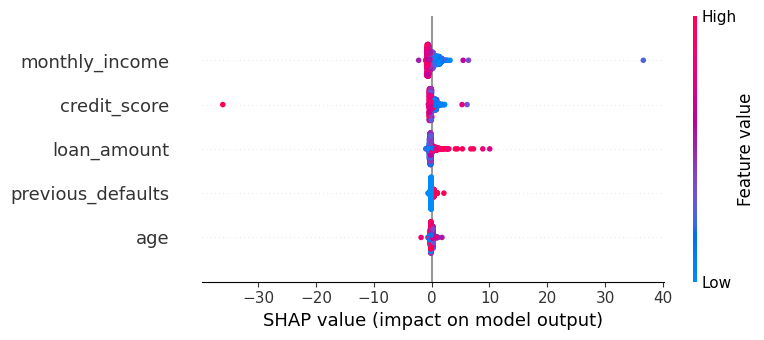

In [16]:
explainer = shap.Explainer(gb)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig('shap_summary.png')

Validasi Model (R Programming)

In [17]:
# Fungsi scorecard
def scorecard(prob, min_score=300, max_score=850):
    return (1 - prob) * (max_score - min_score) + min_score

# Buat DataFrame hasil prediksi dari model Gradient Boosting
df_output = pd.DataFrame({
    'index': X_test.index,  # bisa dianggap ID sementara
    'default': y_test.values,
    'prob': y_prob_gb,
    'scorecard': scorecard(y_prob_gb)
})

# Simpan ke CSV
df_output.to_csv('model_output.csv', index=False)


In [18]:
# Simpan Model untuk pengerjaan bagian C
df = pd.read_csv('/content/model_output.csv')
df.head()

,index,default,prob,scorecard
0,1782,0,0.008490,845.330396
1,3917,0,0.002204,848.787841
2,221,0,0.008265,845.454197
3,2135,0,0.031186,832.847954
4,5224,0,0.001093,849.398900
